# Building structured multi-plot grids

## Conditional small multiples

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

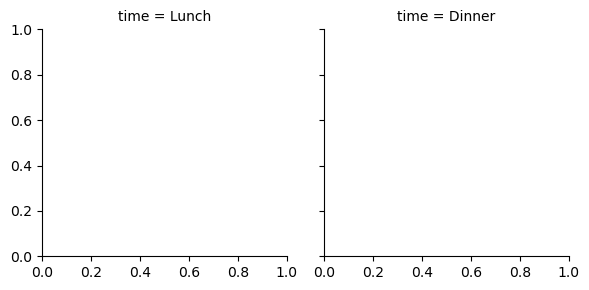

In [14]:
tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, col="time")

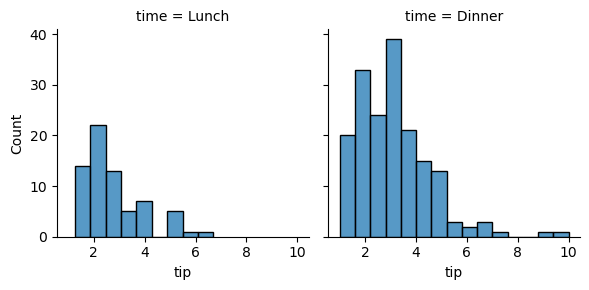

In [15]:
# Let’s look at the distribution of tips in each of these subsets, using a histogram:
g = sns.FacetGrid(tips, col="time")
g.map(sns.histplot, "tip")

- This function will draw the figure and annotate the axes, hopefully producing a finished plot in one step. To make a relational plot, just pass multiple variable names. You can also provide keyword arguments, which will be passed to the plotting function:

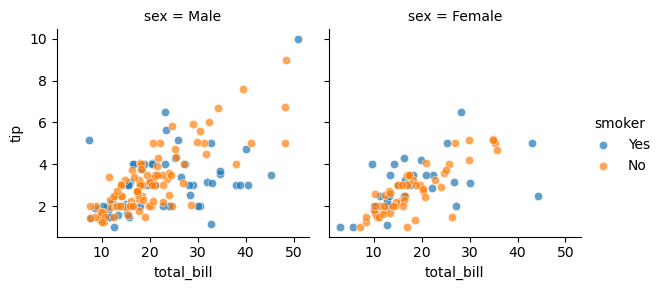

In [16]:
g = sns.FacetGrid(tips, col="sex", hue="smoker")
g.map(sns.scatterplot, "total_bill", "tip", alpha=.7)
g.add_legend()

- There are several options for controlling the look of the grid that can be passed to the class constructor.

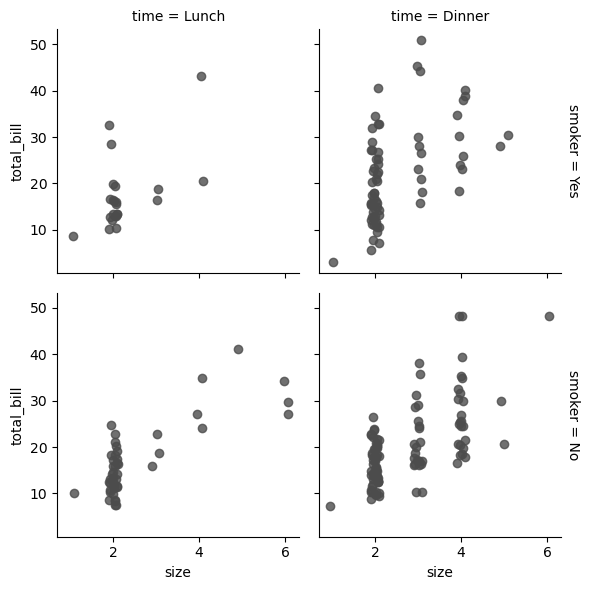

In [17]:
g = sns.FacetGrid(tips, row="smoker", col="time", margin_titles=True)
g.map(sns.regplot, "size", "total_bill", color=".3", fit_reg=False, x_jitter=.1)

- Note that margin_titles isn’t formally supported by the matplotlib API, and may not work well in all cases. In particular, it currently can’t be used with a legend that lies outside of the plot.
- The size of the figure is set by providing the height of each facet, along with the aspect ratio:

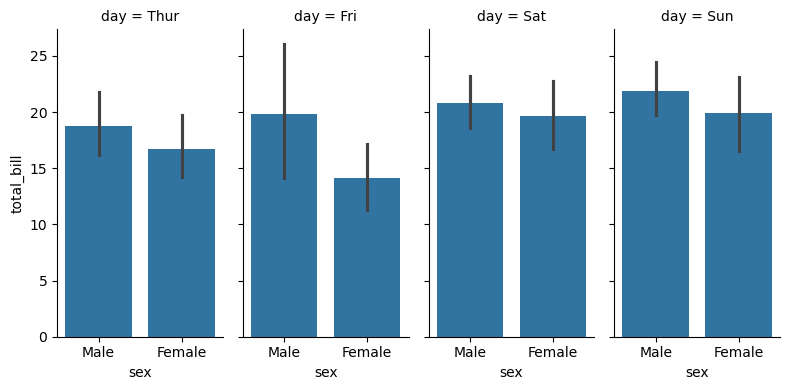

In [18]:
g = sns.FacetGrid(tips, col="day", height=4, aspect=.5)
g.map(sns.barplot, "sex", "total_bill", order=["Male", "Female"])

- The default ordering of the facets is derived from the information in the DataFrame. If the variable used to define facets has a categorical type, then the order of the categories is used. Otherwise, the facets will be in the order of appearance of the category levels. It is possible, however, to specify an ordering of any facet dimension with the appropriate *_order parameter:

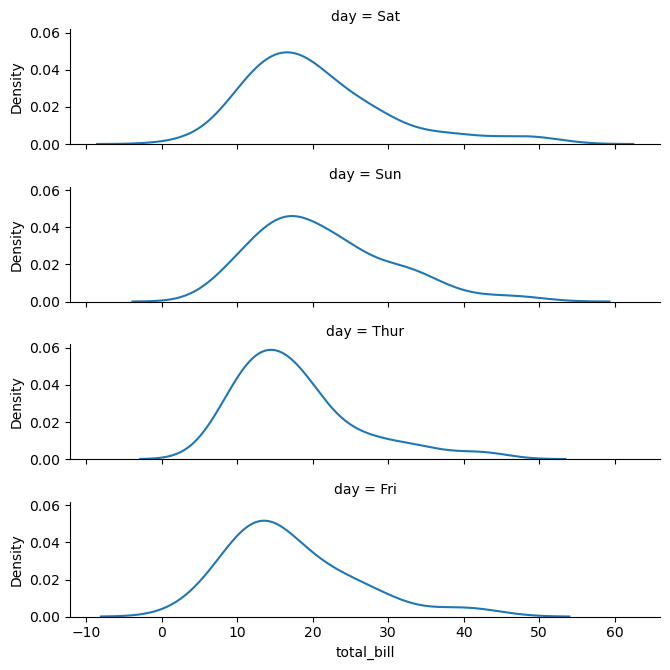

In [19]:
ordered_days = tips.day.value_counts().index
g = sns.FacetGrid(tips, row="day", row_order=ordered_days,
                  height=1.7, aspect=4,)
g.map(sns.kdeplot, "total_bill")

- Any seaborn color palette (i.e., something that can be passed to color_palette()) can be provided. You can also use a dictionary that maps the names of values in the hue variable to valid matplotlib colors:

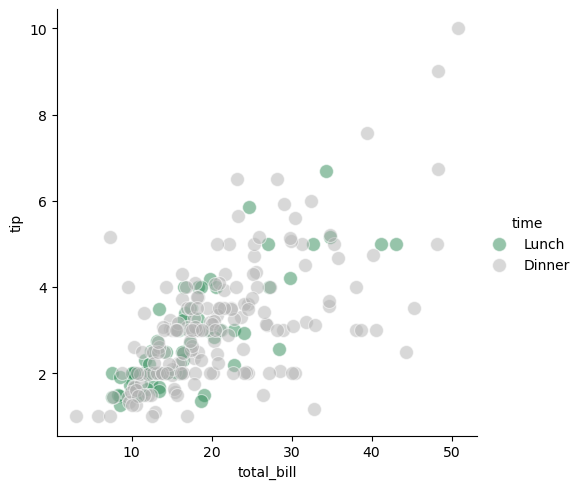

In [20]:
pal = dict(Lunch="seagreen", Dinner=".7")
g = sns.FacetGrid(tips, hue="time", palette=pal, height=5)
g.map(sns.scatterplot, "total_bill", "tip", s=100, alpha=.5)
g.add_legend()

- If you have many levels of one variable, you can plot it along the columns but “wrap” them so that they span multiple rows. When doing this, you cannot use a row variable.

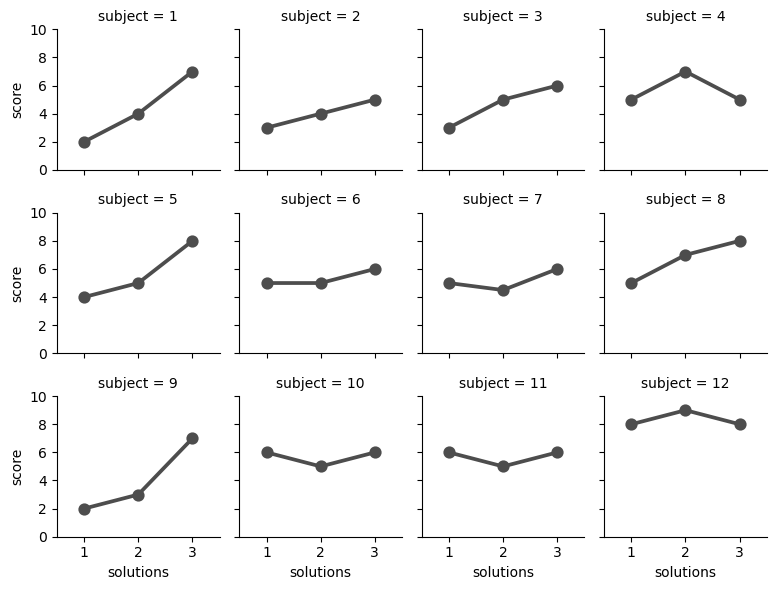

In [21]:
attend = sns.load_dataset("attention").query("subject <= 12")
g = sns.FacetGrid(attend, col="subject", col_wrap=4, height=2, ylim=(0, 10))
g.map(sns.pointplot, "solutions", "score", order=[1, 2, 3], color=".3", errorbar=None)

- Once you’ve drawn a plot using FacetGrid.map() (which can be called multiple times), you may want to adjust some aspects of the plot. There are also a number of methods on the FacetGrid object for manipulating the figure at a higher level of abstraction. The most general is FacetGrid.set(), and there are other more specialized methods like FacetGrid.set_axis_labels(), which respects the fact that interior facets do not have axis labels. For example:

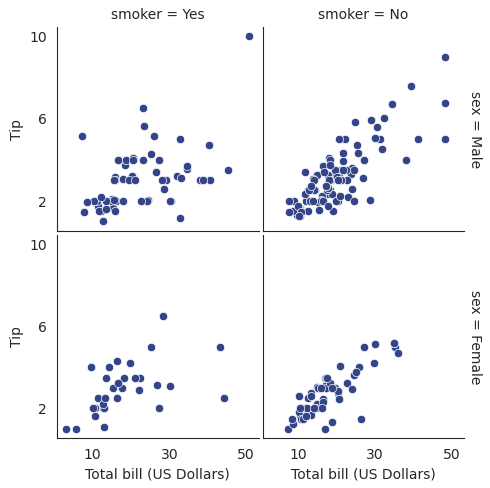

In [22]:
with sns.axes_style("white"):
    g = sns.FacetGrid(tips, row="sex", col="smoker", margin_titles=True, height=2.5)
g.map(sns.scatterplot, "total_bill", "tip", color="#334488")
g.set_axis_labels("Total bill (US Dollars)", "Tip")
g.set(xticks=[10, 30, 50], yticks=[2, 6, 10])
g.figure.subplots_adjust(wspace=.02, hspace=.02)

- For even more customization, you can work directly with the underling matplotlib Figure and Axes objects, which are stored as member attributes at figure and axes_dict, respectively. When making a figure without row or column faceting, you can also use the ax attribute to directly access the single axes.

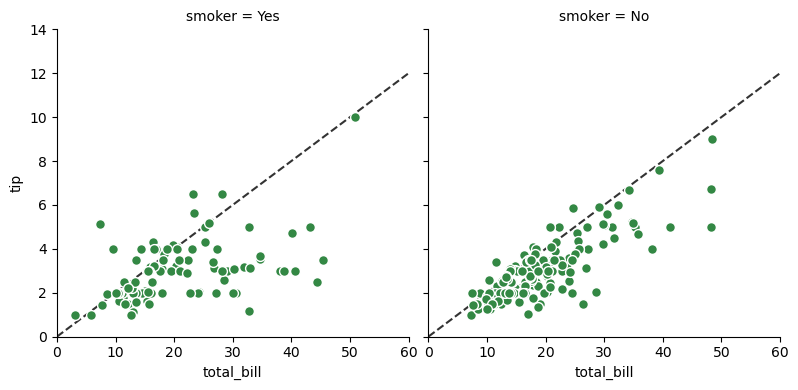

In [23]:
g = sns.FacetGrid(tips, col="smoker", margin_titles=True, height=4)
g.map(plt.scatter, "total_bill", "tip", color="#338844", edgecolor="white", s=50, lw=1)
for ax in g.axes_dict.values():
    ax.axline((0, 0), slope=.2, c=".2", ls="--", zorder=0)
g.set(xlim=(0, 60), ylim=(0, 14))

## Using custom functions
- You’re not limited to existing matplotlib and seaborn functions when using FacetGrid. However, to work properly, any function you use must follow a few rules:
  1. It must plot onto the “currently active” matplotlib Axes. This will be true of functions in the matplotlib.pyplot namespace, and you can call matplotlib.pyplot.gca() to get a reference to the current Axes if you want to work directly with its methods.
2. It must accept the data that it plots in positional arguments. Internally, FacetGrid will pass a Series of data for each of the named positional arguments passed to FacetGrid.map().
3. It must be able to accept color and label keyword arguments, and, ideally, it will do something useful with them. In most cases, it’s easiest to catch a generic dictionary of **kwargs and pass it along to the underlying plotting function.
- Let’s look at minimal example of a function you can plot with. This function will just take a single vector of data for each facet:

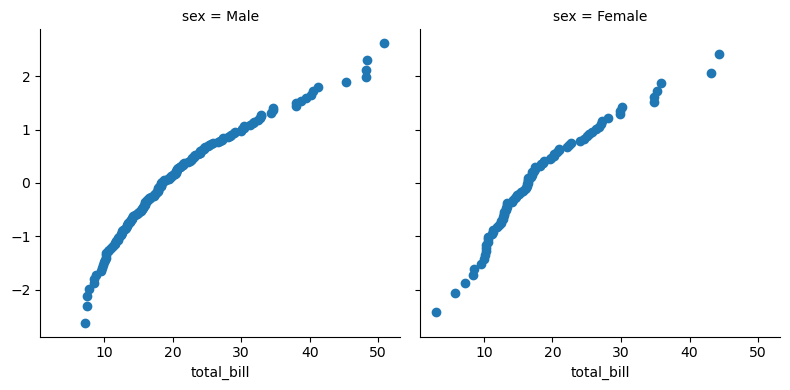

In [24]:
from scipy import stats
def quantile_plot(x, **kwargs):
    quantiles, xr = stats.probplot(x, fit=False)
    plt.scatter(xr, quantiles, **kwargs)

g = sns.FacetGrid(tips, col="sex", height=4)
g.map(quantile_plot, "total_bill")

- If we want to make a bivariate plot, you should write the function so that it accepts the x-axis variable first and the y-axis variable second:

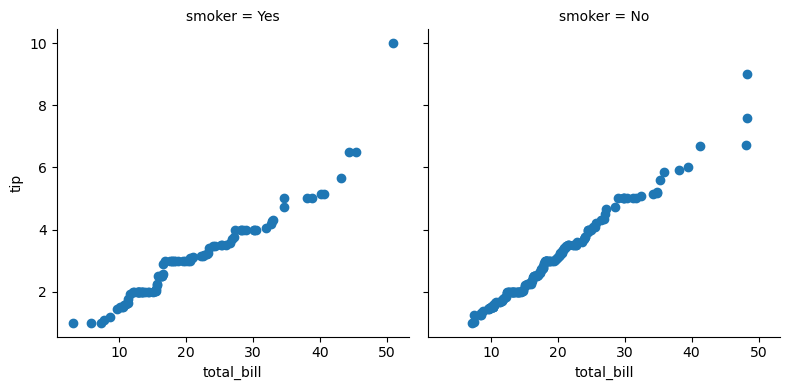

In [25]:
def qqplot(x, y, **kwargs):
    _, xr = stats.probplot(x, fit=False)
    _, yr = stats.probplot(y, fit=False)
    plt.scatter(xr, yr, **kwargs)

g = sns.FacetGrid(tips, col="smoker", height=4)
g.map(qqplot, "total_bill", "tip")

- Because matplotlib.pyplot.scatter() accepts color and label keyword arguments and does the right thing with them, we can add a hue facet without any difficulty:

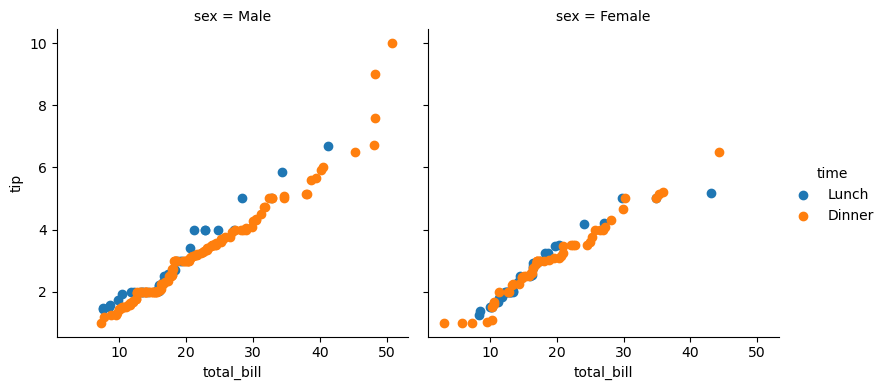

In [26]:
g = sns.FacetGrid(tips, hue="time", col="sex", height=4)
g.map(qqplot, "total_bill", "tip")
g.add_legend()

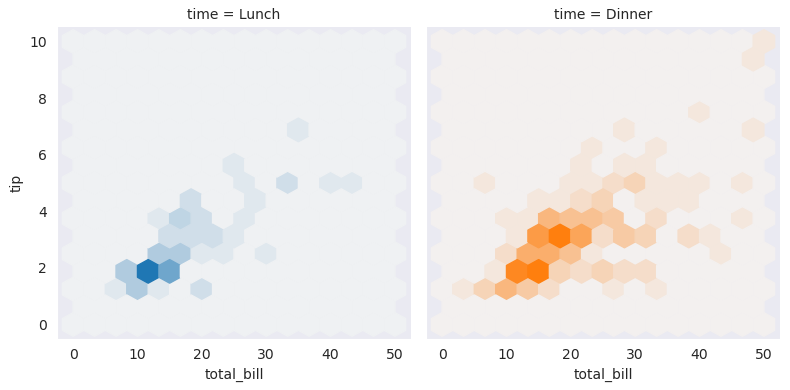

In [27]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=15, cmap=cmap, **kwargs)

with sns.axes_style("dark"):
    g = sns.FacetGrid(tips, hue="time", col="time", height=4)
g.map(hexbin, "total_bill", "tip", extent=[0, 50, 0, 10]);

## Plotting pairwise data relationships
- The basic usage of the class is very similar to FacetGrid. First you initialize the grid, then you pass plotting function to a map method and it will be called on each subplot. There is also a companion function, pairplot() that trades off some flexibility for faster plotting.

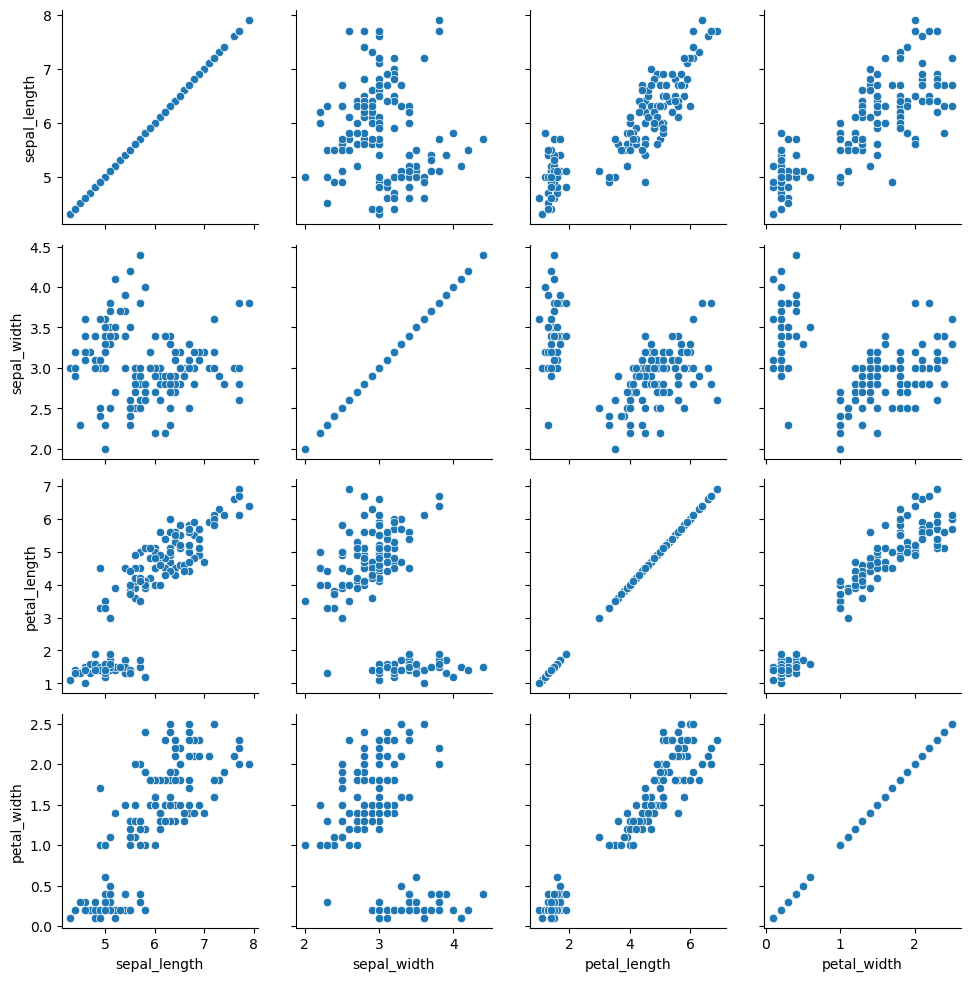

In [28]:
iris = sns.load_dataset("iris")
g = sns.PairGrid(iris)
g.map(sns.scatterplot)

- It’s possible to plot a different function on the diagonal to show the univariate distribution of the variable in each column. Note that the axis ticks won’t correspond to the count or density axis of this plot, though.

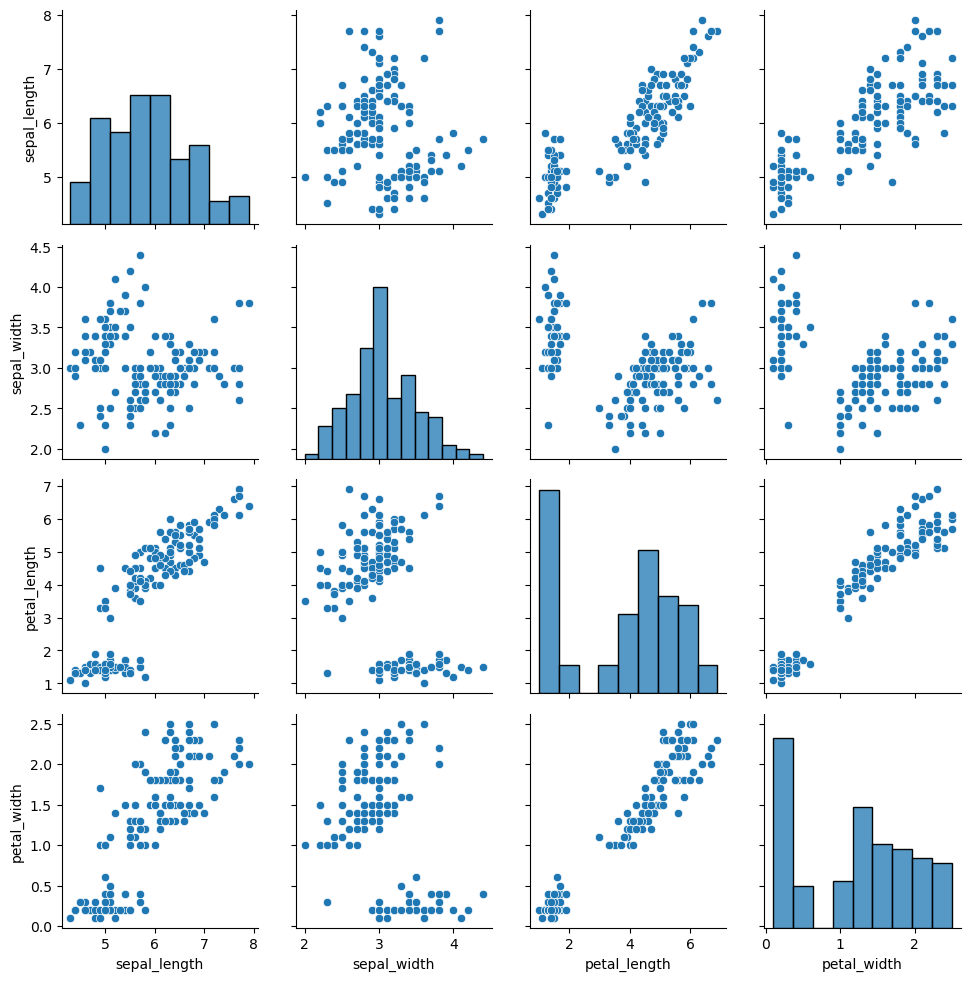

In [29]:
g = sns.PairGrid(iris)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

- A very common way to use this plot colors the observations by a separate categorical variable. For example, the iris dataset has four measurements for each of three different species of iris flowers so you can see how they differ.

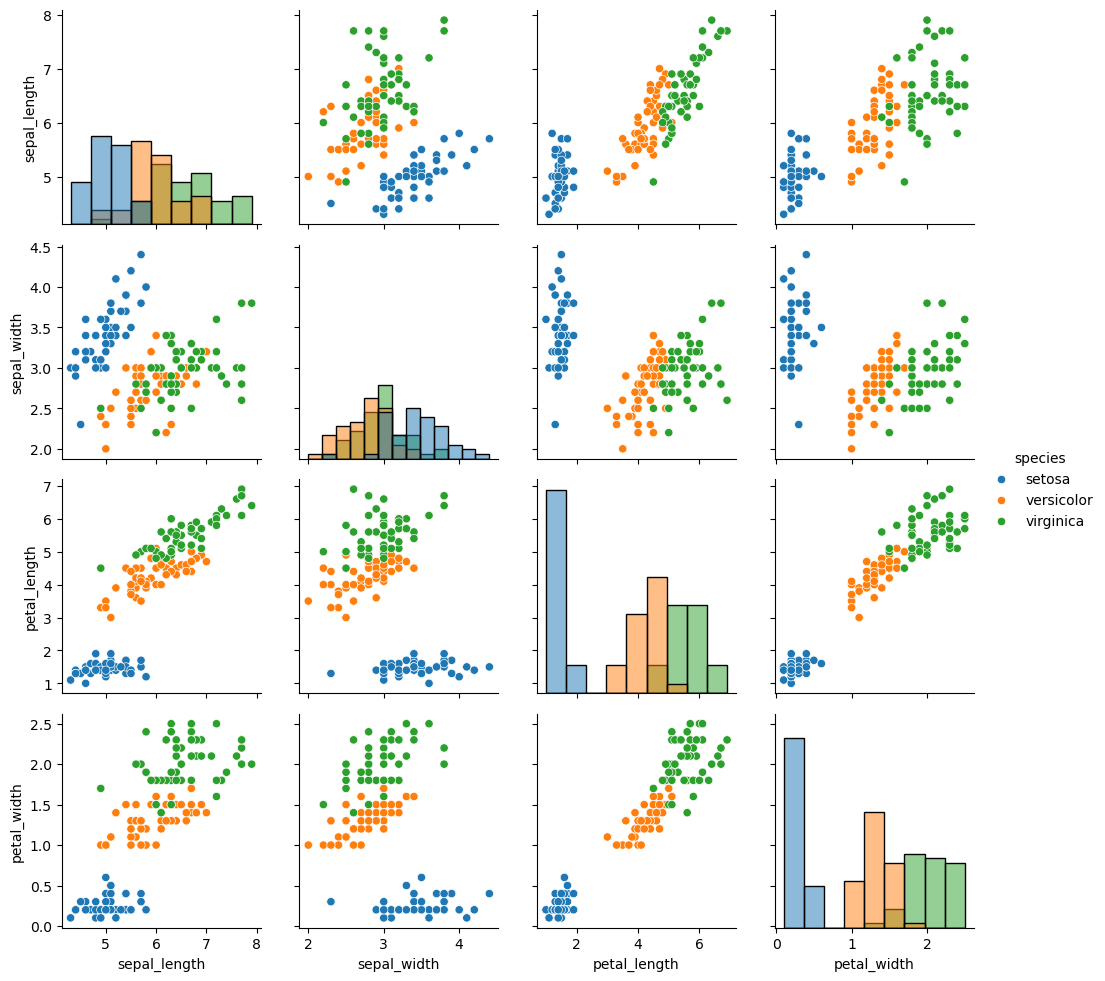

In [30]:
g = sns.PairGrid(iris, hue="species")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

- By default every numeric column in the dataset is used, but you can focus on particular relationships if you want.

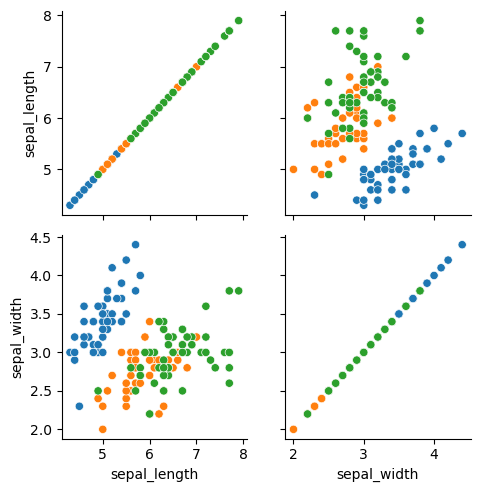

In [31]:
g = sns.PairGrid(iris, vars=["sepal_length", "sepal_width"], hue="species")
g.map(sns.scatterplot)

- It’s also possible to use a different function in the upper and lower triangles to emphasize different aspects of the relationship.

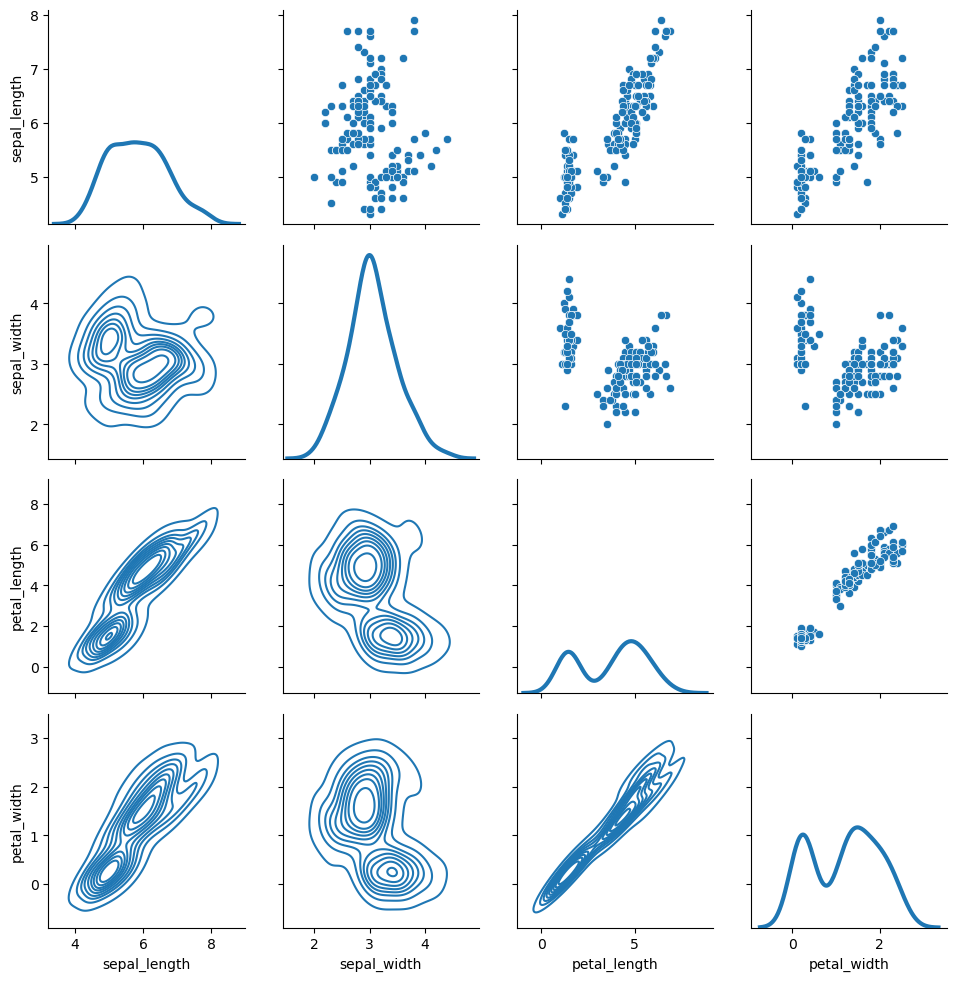

In [32]:
g = sns.PairGrid(iris)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

- The square grid with identity relationships on the diagonal is actually just a special case, and you can plot with different variables in the rows and columns

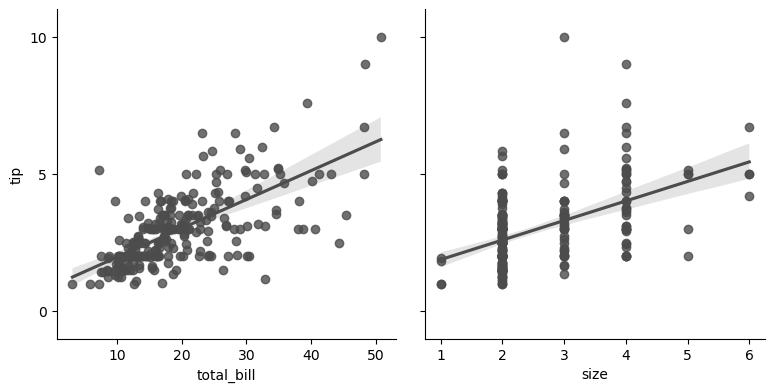

In [33]:
g = sns.PairGrid(tips, y_vars=["tip"], x_vars=["total_bill", "size"], height=4)
g.map(sns.regplot, color=".3")
g.set(ylim=(-1, 11), yticks=[0, 5, 10])

- Of course, the aesthetic attributes are configurable. For instance, you can use a different palette (say, to show an ordering of the hue variable) and pass keyword arguments into the plotting functions.

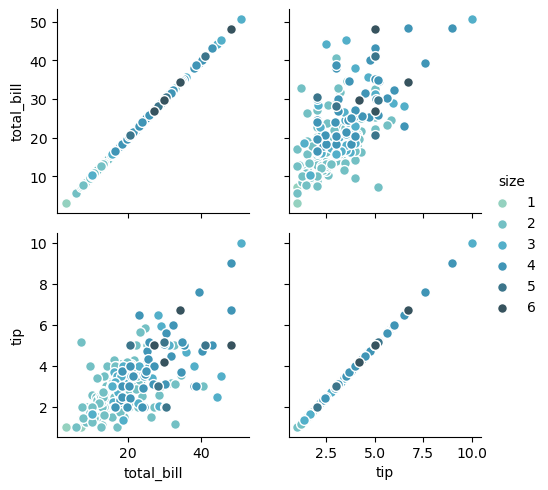

In [34]:
g = sns.PairGrid(tips, hue="size", palette="GnBu_d")
g.map(plt.scatter, s=50, edgecolor="white")
g.add_legend()

- PairGrid is flexible, but to take a quick look at a dataset, it can be easier to use pairplot(). This function uses scatterplots and histograms by default, although a few other kinds will be added (currently, you can also plot regression plots on the off-diagonals and KDEs on the diagonal).

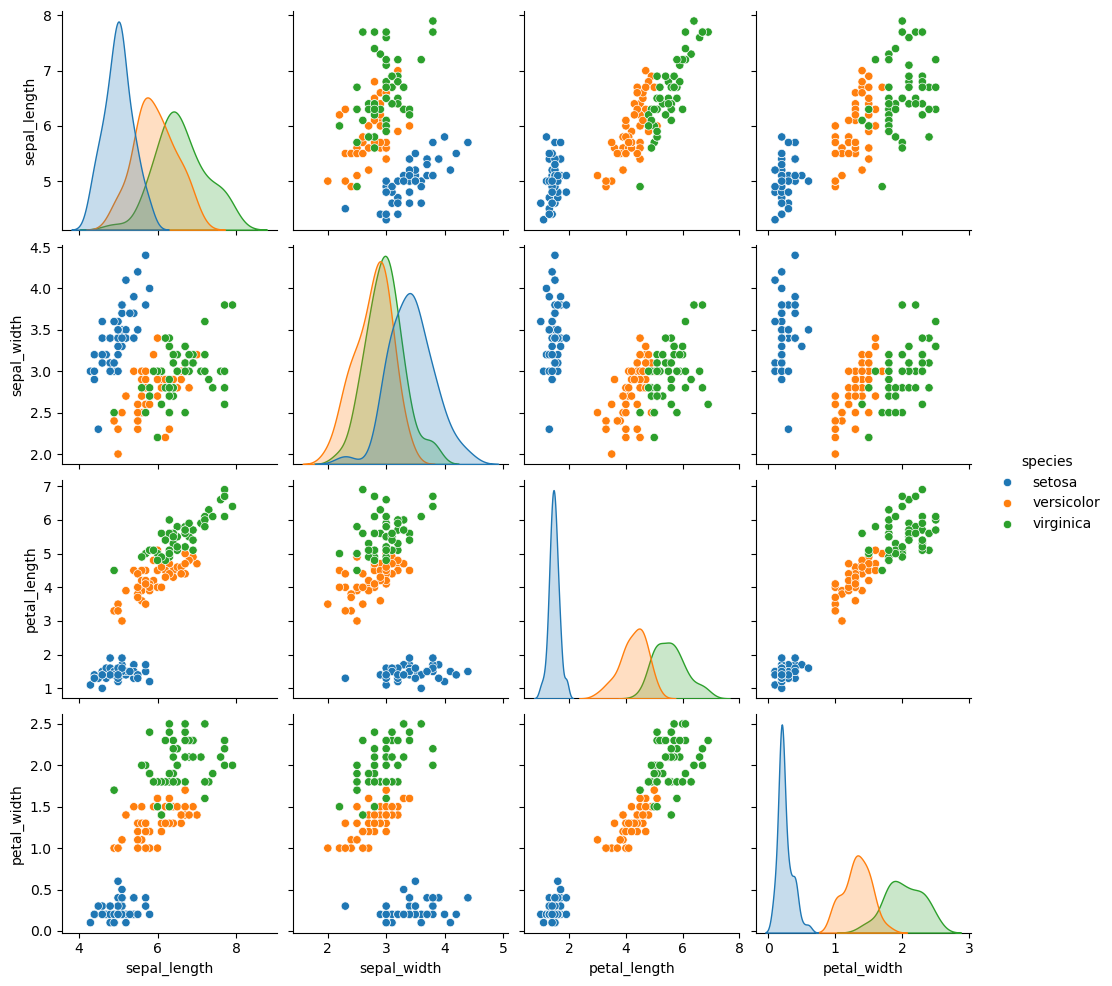

In [35]:
sns.pairplot(iris, hue="species", height=2.5)

- You can also control the aesthetics of the plot with keyword arguments, and it returns the PairGrid instance for further tweaking.

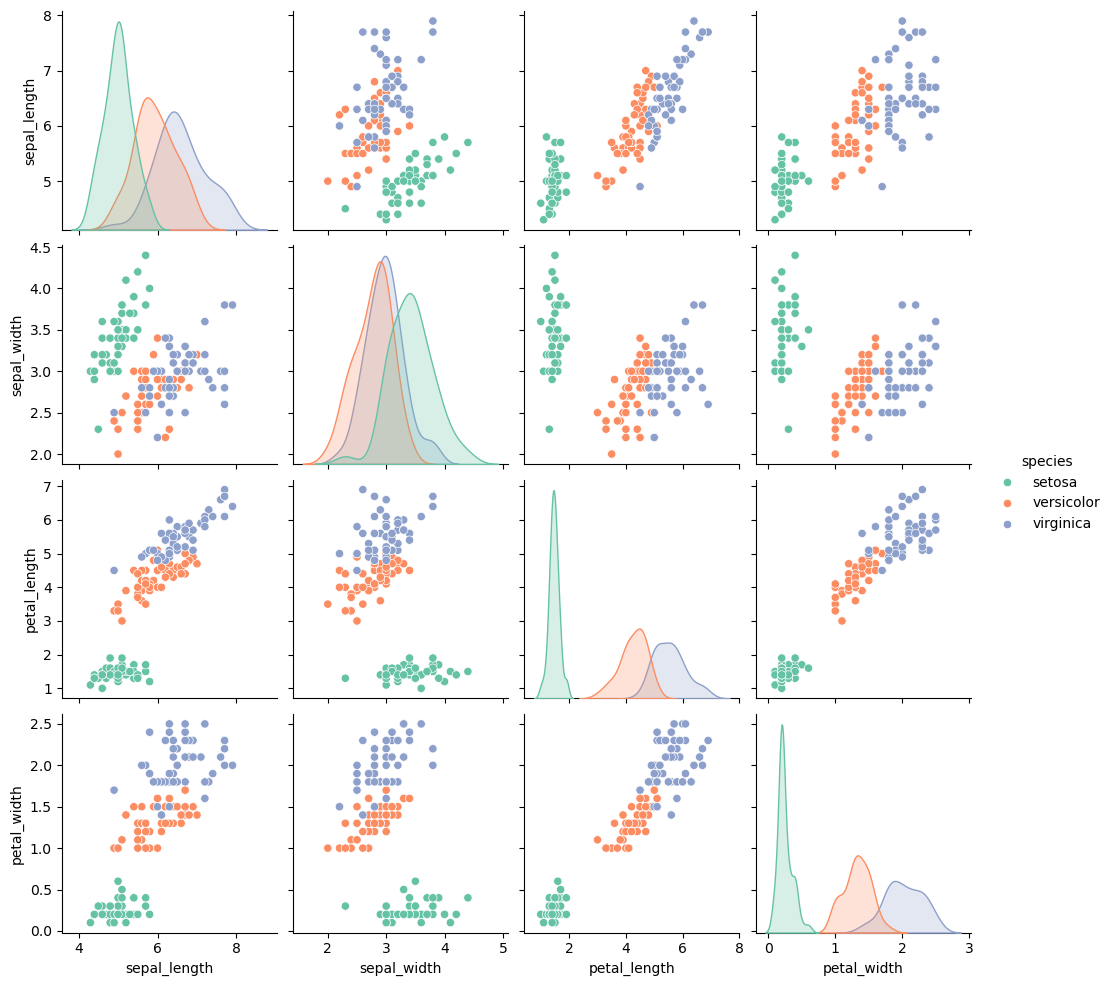

In [36]:
g = sns.pairplot(iris, hue="species", palette="Set2", diag_kind="kde", height=2.5)